In [190]:
!rm -rf pytorch_utils
!git clone https://github.com/rahuldsce/pytorch_utils.git

Cloning into 'pytorch_utils'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 34 (delta 8), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (34/34), 13.42 KiB | 13.42 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [191]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [192]:
import torch.nn as nn
import torch.nn.functional as F

In [193]:
from pytorch_utils import dataset

In [194]:
train, test = dataset.cifar10()

Files already downloaded and verified
Files already downloaded and verified


In [195]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [196]:
class Net(nn.Module):
  def conv_block (self, in_channels, out_channels, kernel_size, padding = 1) :
        return nn.Sequential(
              nn.Conv2d (in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding, bias = False),
              nn.ReLU(),
              nn.GroupNorm(2, out_channels),
              nn.Dropout(0.1))

  def trans_block (self, in_channels, out_channels):
    return nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size = 1, padding = 0, bias = False))

  def out_block(self, in_channels, kernel_size = 1):
    return nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=10, kernel_size = kernel_size, padding = 0, bias = False))

  def __init__(self, opts=[]):
        super(Net, self).__init__()
        self.conv1 = self.conv_block(3, 16, 3) #32
        self.conv2 = self.conv_block(16, 32, 3) #32
        self.trans1 = self.trans_block(32, 16) #32
        self.conv3 = self.conv_block(16, 16, 3) #16
        self.conv4 = self.conv_block(16, 32, 3) #16
        self.conv5 = self.conv_block(32, 32, 3) #16
        self.trans2 = self.trans_block(32, 16) #16
        self.conv6 = self.conv_block(16, 16, 3) #8
        self.conv7 = self.conv_block(16, 32, 3) #8
        self.conv8 = self.conv_block(32, 32, 3) #8
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=8))
        self.out = self.out_block(32, 1)
        self.pool = nn.MaxPool2d(2, 2)


  def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.trans1(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      x = self.trans2(x)
      x = self.conv6(x)
      x = self.conv7(x)
      x = self.conv8(x)
      x = self.gap(x)
      x = self.out(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [197]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 16, 16, 16]             512
           Conv2d-11           [-1, 16, 16, 16]           2,304
             ReLU-12           [-1, 16, 16, 16]               0
        GroupNorm-13           [-1, 16, 16, 16]              32
          Dropout-14           [-1, 16,

In [198]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [199]:
import torch.optim as optim
import torch.nn as nn

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
EPOCHS = 20

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=1.75283682346344 Batch_id=390 Accuracy=29.18: 100%|██████████| 391/391 [00:28<00:00, 13.93it/s]



Test set: Average loss: 1.7079, Accuracy: 3782/10000 (37.82%)

EPOCH: 1


Loss=1.6736071109771729 Batch_id=390 Accuracy=38.65: 100%|██████████| 391/391 [00:26<00:00, 14.86it/s]



Test set: Average loss: 1.5447, Accuracy: 4276/10000 (42.76%)

EPOCH: 2


Loss=1.6051504611968994 Batch_id=390 Accuracy=45.46: 100%|██████████| 391/391 [00:25<00:00, 15.06it/s]



Test set: Average loss: 1.4256, Accuracy: 4870/10000 (48.70%)

EPOCH: 3


Loss=1.3215105533599854 Batch_id=390 Accuracy=50.43: 100%|██████████| 391/391 [00:26<00:00, 15.01it/s]



Test set: Average loss: 1.3875, Accuracy: 5146/10000 (51.46%)

EPOCH: 4


Loss=1.2309372425079346 Batch_id=390 Accuracy=54.99: 100%|██████████| 391/391 [00:26<00:00, 14.99it/s]



Test set: Average loss: 1.1748, Accuracy: 5741/10000 (57.41%)

EPOCH: 5


Loss=1.3066210746765137 Batch_id=390 Accuracy=58.00: 100%|██████████| 391/391 [00:24<00:00, 15.70it/s]



Test set: Average loss: 1.2263, Accuracy: 5626/10000 (56.26%)

EPOCH: 6


Loss=1.0633957386016846 Batch_id=390 Accuracy=60.17: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s]



Test set: Average loss: 1.0632, Accuracy: 6212/10000 (62.12%)

EPOCH: 7


Loss=1.1099755764007568 Batch_id=390 Accuracy=61.94: 100%|██████████| 391/391 [00:24<00:00, 15.69it/s]



Test set: Average loss: 1.0438, Accuracy: 6224/10000 (62.24%)

EPOCH: 8


Loss=0.979611873626709 Batch_id=390 Accuracy=63.53: 100%|██████████| 391/391 [00:24<00:00, 15.75it/s]



Test set: Average loss: 1.0356, Accuracy: 6333/10000 (63.33%)

EPOCH: 9


Loss=1.0350863933563232 Batch_id=390 Accuracy=64.87: 100%|██████████| 391/391 [00:25<00:00, 15.45it/s]



Test set: Average loss: 1.0143, Accuracy: 6376/10000 (63.76%)

EPOCH: 10


Loss=1.014931321144104 Batch_id=390 Accuracy=66.20: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s]



Test set: Average loss: 1.0173, Accuracy: 6467/10000 (64.67%)

EPOCH: 11


Loss=0.8252061605453491 Batch_id=390 Accuracy=67.33: 100%|██████████| 391/391 [00:25<00:00, 15.42it/s]



Test set: Average loss: 0.9025, Accuracy: 6833/10000 (68.33%)

EPOCH: 12


Loss=0.9413025975227356 Batch_id=390 Accuracy=67.84: 100%|██████████| 391/391 [00:25<00:00, 15.38it/s]



Test set: Average loss: 0.8845, Accuracy: 6850/10000 (68.50%)

EPOCH: 13


Loss=0.7792872786521912 Batch_id=390 Accuracy=69.04: 100%|██████████| 391/391 [00:25<00:00, 15.53it/s]



Test set: Average loss: 0.9399, Accuracy: 6791/10000 (67.91%)

EPOCH: 14


Loss=0.8788391351699829 Batch_id=390 Accuracy=69.48: 100%|██████████| 391/391 [00:25<00:00, 15.45it/s]



Test set: Average loss: 0.9344, Accuracy: 6716/10000 (67.16%)

EPOCH: 15


Loss=0.9917834401130676 Batch_id=390 Accuracy=70.44: 100%|██████████| 391/391 [00:25<00:00, 15.55it/s]



Test set: Average loss: 0.8518, Accuracy: 7011/10000 (70.11%)

EPOCH: 16


Loss=0.741582989692688 Batch_id=390 Accuracy=71.09: 100%|██████████| 391/391 [00:24<00:00, 15.89it/s]



Test set: Average loss: 0.8660, Accuracy: 6996/10000 (69.96%)

EPOCH: 17


Loss=0.9716171026229858 Batch_id=390 Accuracy=71.72: 100%|██████████| 391/391 [00:24<00:00, 15.78it/s]



Test set: Average loss: 0.7690, Accuracy: 7321/10000 (73.21%)

EPOCH: 18


Loss=0.9787394404411316 Batch_id=390 Accuracy=72.06: 100%|██████████| 391/391 [00:24<00:00, 15.97it/s]



Test set: Average loss: 0.8384, Accuracy: 7069/10000 (70.69%)

EPOCH: 19


Loss=0.7330220341682434 Batch_id=390 Accuracy=72.82: 100%|██████████| 391/391 [00:23<00:00, 16.32it/s]



Test set: Average loss: 0.7959, Accuracy: 7214/10000 (72.14%)



In [200]:
torch.save(model.state_dict(), f"./cifar_10_gn.pth")

In [203]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def show_misclassified_images_from_model(model, model_path, data_loader, class_labels, image_count):
  model.load_state_dict(torch.load(model_path))
  model.to(device)
  model.eval()

  correct = 0
  figure = plt.figure(figsize=(15,15))
  count = 0
  with torch.no_grad():
      for data, target in data_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

          for idx in range(len(pred)):
            i_pred, i_act = pred[idx], target[idx]
            if i_pred != i_act:
                annotation = "Actual: %s, Predicted: %s" % (class_labels[i_act], class_labels[i_pred])
                count += 1
                plt.subplot(5, 2, count)
                plt.axis('off')
                imshow(data[idx].cpu())
                plt.annotate(annotation, xy=(0,0), xytext=(0,-1.2), fontsize=13)
            if count == image_count:
                return

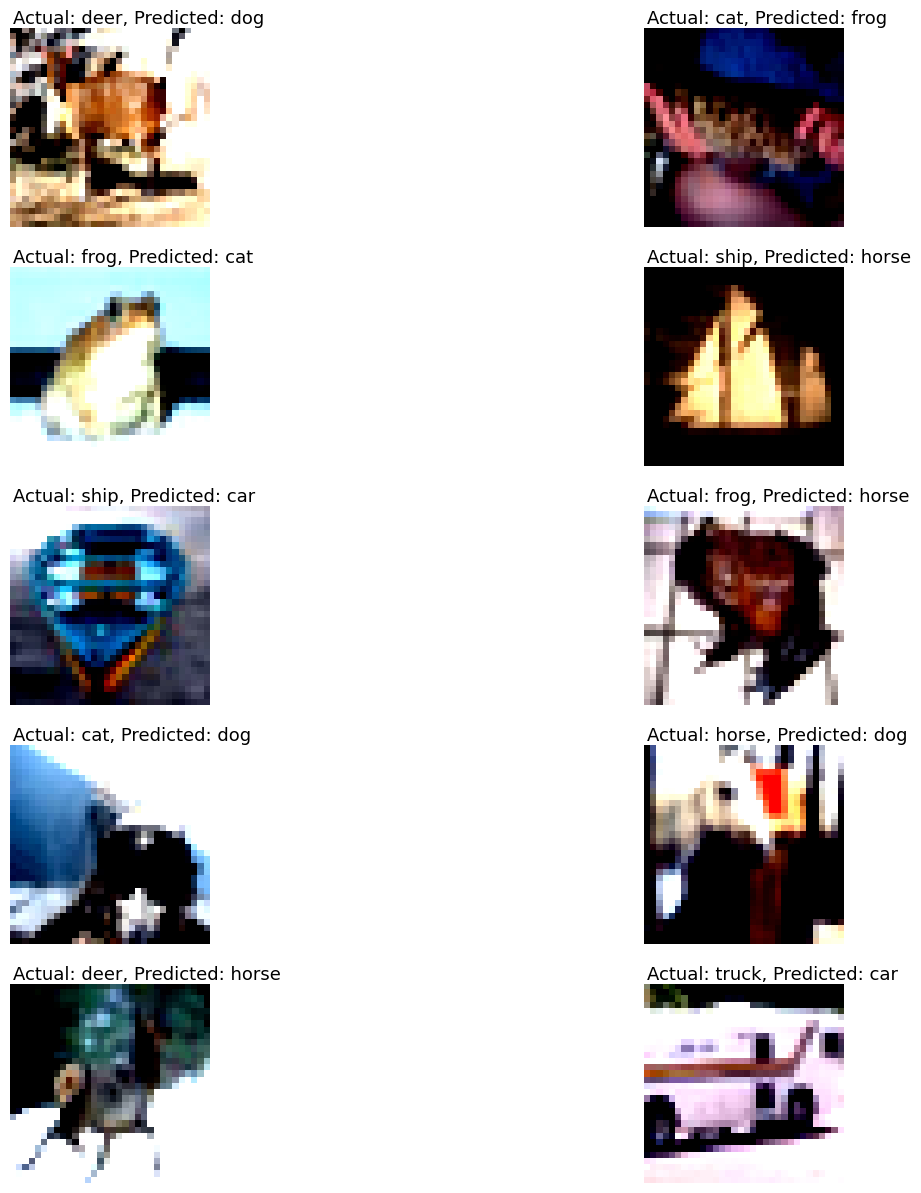

In [204]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
show_misclassified_images_from_model(model, "./cifar_10_gn.pth", test_loader, classes, 10)